# How to derive moment equations in Compartor
$$
\def\n{\mathbf{n}}
\def\x{\mathbf{x}}
\def\N{\mathbb{\mathbb{N}}}
\def\X{\mathbb{X}}
\def\NX{\mathbb{\N_0^\X}}
\def\C{\mathcal{C}}
\def\Jc{\mathcal{J}_c}
\def\DM{\Delta M_{c,j}}
\newcommand\diff{\mathop{}\!\mathrm{d}}
\def\Xc{\mathbf{X}_c}
\def\Yc{\mathbf{Y}_c}
\newcommand{\muset}[1]{\dot{\{}#1\dot{\}}}
$$

In [1]:
# initialize sympy printing (for latex output)
from sympy import init_printing, Symbol
init_printing()

# import functions and classes for compartment models
from compartor import *

## Moment declaration

The purpose of Compartor is to generate the moment equations: these are a system of ODEs that describes the time evolution of a set of expected population moments. 

To denote a particular moment, use the `Moment` class. It takes as constructor arguments the integer exponents in each species. For instance, the following list

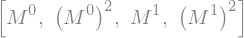

In [2]:
moments = [
    Moment(0),
    Moment(0)**2,
    Moment(1),
    Moment(1)**2
]
display(moments)

denotes 4 moment expressions of a system comprising $D=1$ chemical species. Instead, this list

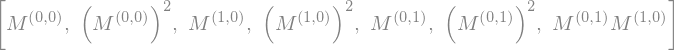

In [3]:
moments = [
    Moment(0,0),
    Moment(0,0)**2,
    Moment(1,0),
    Moment(1,0)**2,
    Moment(0,1),
    Moment(0,1)**2,
    Moment(1,0)*Moment(0,1)
]
display(moments)

collects 7 moment expressions of a system of dimensionality $D=2$. 

Compartor offers two main modalities to handle the derivation of the moment equations for a given compartment population model.

The user can choose a fully automated derivation, where possible further moment dependencies and moment closures are managed internally by the tool. The automated usage is usually recommended, especially when the user seeks for a one-shot solution to create a closed system of moment equations.

Alternatively, more experienced users might opt for a step-by-step analysis of the moment equations, which permits a more gradual control on the included moment statistics and on the application of moment closures.

In this notebook, we illustrate both automated and manual derivation for the case study shown in the paper.

First, we specify the model (see (1) HOWTO - define the model).

In [4]:
x = Content('x')
y = Content('y')

# Intake Distribution
pi_I = OutcomeDistribution.Poisson(Symbol('\pi_{I}(y; \lambda)'),y[0],Symbol('\lambda'))


Intake      = TransitionClass( {}        -to> [(y[0],0)],   'k_I', pi=pi_I, name='I')
Fusion      = TransitionClass( [x] + [y] -to> [x+y],        'k_F',          name='F')
Conversion  = TransitionClass( [x]       -to> [x + (-1,1)], 'k_c', x[0],    name='c')
Degradation = TransitionClass( [x]       -to> [x + (0,-1)], 'k_d', x[1],    name='d')

transitions = [ Intake, Fusion, Conversion, Degradation]

display_transition_classes(transitions)

Display.__str__: TODO

## Automated derivation of moment equations
The function `automated_moment_equations()` handles automatically the process of moment identification, equation generation and moment closure for a provided model. 

`automated_moment_equations()` takes the following arguments: 
* the number `D` of chemical species of the system 
* the set of transition classes defining the model 
* optionally, a list of `Moments` that must be included the system of moment equations. 

When the optional set of moments is not given, `automated_moment_equations()` outputs the smallest closed system of moment equations containing at least the total number number and the total amount of chemical species. Let's call `automated_moment_equations()` on the `transition` of the case study:

In [5]:
equations = automated_moment_equations(2, transitions)

Computed moment equations for desired moments $\left< N\right> $, $\left< M^{\left(1, 0\right)}\right> $, and $\left< M^{\left(0, 1\right)}\right> $.

Equations were iteratively added for $\left< N^{2}\right> $.

Gamma closures were substituted for $\left< N^{3}\right> $.

The function outputs a summary of the operations executed in the derivation and returns the final system of moment equations. To display the derived equations, use the `display_moment_equations()` function.

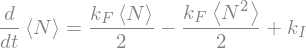

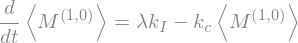

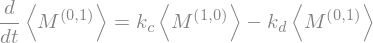

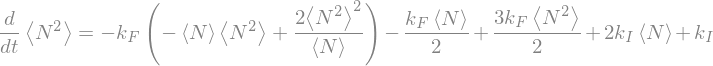

In [6]:
display_moment_equations(equations)

Optionally, a list of moments can be passed to `automated_moment_equations()` to require them to be included in the system of moment equations.

In [7]:
desired_moments = [Moment(0,0), Moment(0,1)**2]
equations = automated_moment_equations(2, transitions, desired_moments)

Computed moment equations for desired moments $\left< N\right> $ and $\left< {\left(M^{\left(0, 1\right)}\right)}^{2}\right> $.

Equations were iteratively added for $\left< M^{\left(0, 1\right)}\right> $, $\left< N^{2}\right> $, $\left< M^{\left(1, 0\right)}\right> $, $\left< M^{\left(0, 1\right)} M^{\left(1, 0\right)}\right> $, and $\left< {\left(M^{\left(1, 0\right)}\right)}^{2}\right> $.

Gamma closures were substituted for $\left< N^{3}\right> $.

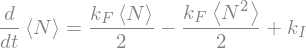

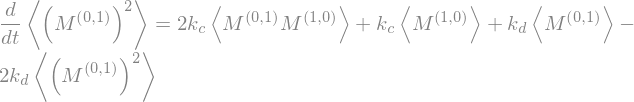

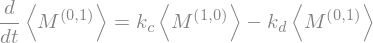

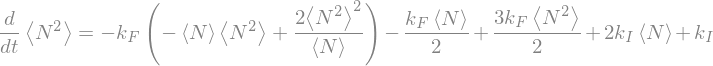

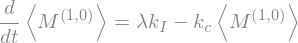

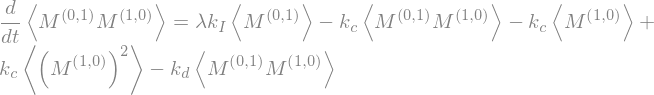

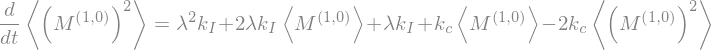

In [8]:
display_moment_equations(equations)

In the latter case, further moments and more closures were required to converge to a closed system of equations.

Internally, the function `automated_moment_equations()` works by applying in iterative fashion the different steps that would occur in the manual derivation. For advanced users, it is then useful to get an idea of the step-by-step derivation of the moment equations as reported in the following.

## Step-by-step derivation of moment equations

In the manual derivation, the user needs to specify a set of moment of interest. Considering again the case study, we define a set of moments which we aim to characterize:

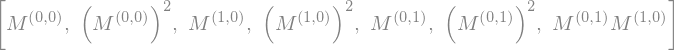

In [9]:
moments = [
    Moment(0,0),
    Moment(0,0)**2,
    Moment(1,0),
    Moment(1,0)**2,
    Moment(0,1),
    Moment(0,1)**2,
    Moment(1,0)*Moment(0,1)
]
display(moments)

Then, call the function `compute_moment_equations()` to generate the moment ODES for the given model and the desired set of moments

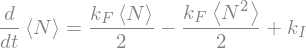

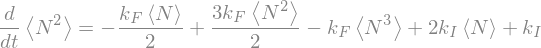

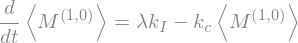

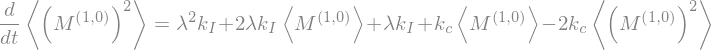

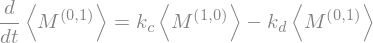

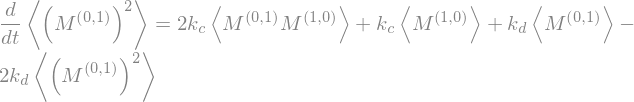

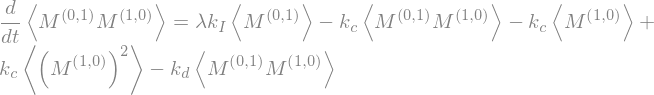

**The system is not closed!** Moment equations are missing for:

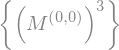

In [10]:
equations = compute_moment_equations(transitions, moments)
display_moment_equations(equations)

The `display_moment_equations()` function outputs a warning when the system is not closed, and which moments are missing. (This output can be suppressed by passing the optional second argument `display_moment_equations(equations, print_missing=False)`).

These "missing" moments are moment expressions whose expectation occurs on the right-hand side of an equation but which are not governed by the system. They can also be computed using the `get_missing_moments()` function.

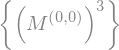

In [11]:
missing = get_missing_moments(equations)
missing

At this point, the user can decide to add the missing moments to the current list (e.g. `moments += list(missing)`) and reiterate the derivation by calling `compute_moment_equations()`, or to apply a moment closure to replace the missing moments with functions of those already available.

### Moment closures

The moment equations are usually not in closed form for a large class of models. In those cases, expanding the moment dynamics does not help to converge to a closed system of equations. Thus, it is necessary to resort to moment closure schemes.

A moment closure is an expression that replaces moments of higher order with functions of moments of lower order. Thus, an open system of equations can be converted into an approximated closed system of equations. In Compartor, the following closure functions can be applied to a list of `missing` moments:
* `gamma_closures()` applies a third-order multivariate Gamma closure,
* `meanfield_closures()` applies a meanfield closure,
* `hybrid_closures()` applies first the Gamma closure and then the meanfield closure to those moments not treatable by the Gamma closure.

In the case above, the Gamma closure is suited to close the third-order missing moment. Thus, we can compute the closure

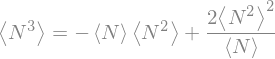

In [12]:
closures = gamma_closures(missing)
display_closures(closures)

and substitute it in `equations` with the function `substitute_closures()`

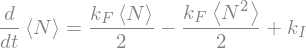

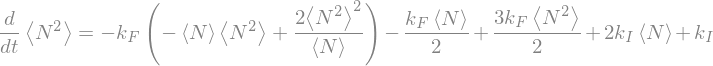

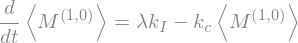

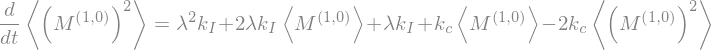

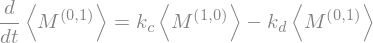

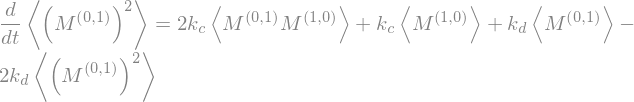

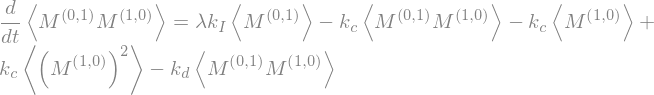

In [13]:
equations = substitute_closures(equations, closures)
display_moment_equations(equations)

The system of equations is now closed and ready to be solved.

The usage of the meanfield and the hybrid closure is analogous, but typically is associated with a greater approximation error. This is why the function `automated_moment_equations()`, which was introduced in the previous section, prioritizes the Gamma closure and only resorts to meanfield (thus, the hybrid scheme) when the Gamma closure is not applicable.